In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

import seaborn as sns
import torch
from torch import nn
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data_points, data_labels):
        self.data_points = data_points
        self.data_labels = data_labels

    def __len__(self):
        return len(self.data_labels)

    def __getitem__(self, idx):
        return self.data_points[idx], self.data_labels[idx]

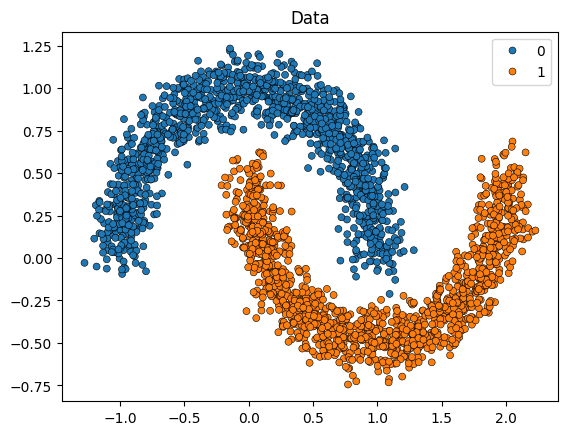

In [3]:
amount = 2500
points, labels = make_moons(n_samples=amount, shuffle=True, noise=0.1, random_state=0)

my_moons = CustomDataset(points, labels)

sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=labels, marker="o", s=25, edgecolor="k", legend=True
).set_title("Data")
plt.show()

X = torch.from_numpy(points).to(dtype=torch.float32)
y = torch.from_numpy(labels).to(dtype=torch.float32)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
def flatten_tuples(list_of_tuples):
    new_list = []
    for row in list_of_tuples:
        if isinstance(row, tuple):
            for item in row:
                    new_list.append(item)
        else:
            new_list.append(row)
    # return [item for row in matrix for item in row]
    return new_list

In [6]:
class MLP(nn.Module):
    def __init__(self, data_size, layers_sizes, activations):
        super().__init__()
        # self.flatten = nn.Flatten()
        torch.manual_seed(2)

        all_sizes = [data_size] + layers_sizes
        tuples_for_linear = [(all_sizes[i], all_sizes[i+1]) for i in range(len(all_sizes) - 1)]
                
        all_instructions = list(zip(tuples_for_linear[:-1], activations))
        all_instructions.append(tuples_for_linear[-1])
        
        # print(all_instructions)

        modules = flatten_tuples([(nn.Linear(i[0][0], i[0][1]), i[1]) for i in all_instructions[:-1]] + [nn.Linear(all_instructions[-1][0], all_instructions[-1][1])])
        # print(modules)
        
        self.stack = nn.Sequential(*modules)  # thanks allenye0119 of https://discuss.pytorch.org/t/append-for-nn-sequential-or-directly-converting-nn-modulelist-to-nn-sequential/7104
        
        # self.linear_relu_stack = nn.Sequential(  # test for comparison purposes
        #     nn.Linear(28*28, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 10),
        # )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.stack(x)
        return logits

In [7]:
model = MLP(X.shape[1], [50, 50, 1], [nn.ReLU(), nn.ReLU()]).to(device)

In [8]:
model.stack

Sequential(
  (0): Linear(in_features=2, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=1, bias=True)
)

In [9]:
# model.linear_relu_stack

In [10]:
learning_rate = 0.001
batch_size = 64

# loss_func = nn.BCELoss()
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
my_moons_dataloader = DataLoader(my_moons, batch_size=64, shuffle=True)

In [11]:
# print(list(my_moons_dataloader)[0])

In [12]:
def training_loop(dataloader, model, loss_func, optimizer, epochs=100):
    loss_after_epoch = []
    loss_list = []
    size = len(dataloader.dataset)
    model.train()
    for i in range(epochs):
        for batch, (XX, yy) in enumerate(dataloader):
            optimizer.zero_grad()
            predict = model(XX.float()).flatten()  # why sigmoid here but not when getting the model's output predictions? how does that help the training loop?
            loss = loss_func(predict, yy.float())  # leaving the comment above here as a reminder to write questions down even if they seem dumb
            
            loss_list.append(loss.item())
            
            loss.backward()
            optimizer.step()
            
            # if batch%10 == 0:
            #     print(f'Batch {batch}')
            
        # if i%10 == 0:
        #     print(f"loss: {loss.item():>7f}")
        
        print(f"loss: {loss.item():>7f}")

        loss_after_epoch.append(loss.item())
        
    plt.plot(loss_list)
    plt.show()
    plt.plot(loss_after_epoch)
    plt.show()

loss: 0.487110
loss: 0.296277
loss: 0.127258
loss: 0.175950
loss: 0.443036
loss: 0.107117
loss: 0.390721
loss: 0.027955
loss: 0.020576
loss: 0.005565
loss: 0.010118
loss: 0.002365
loss: 0.006268
loss: 0.004387
loss: 0.001841
loss: 0.002121
loss: 0.002301
loss: 0.059116
loss: 0.001069
loss: 0.001970
loss: 0.002619
loss: 0.000202
loss: 0.000881
loss: 0.004224
loss: 0.000128
loss: 0.000578
loss: 0.014756
loss: 0.000808
loss: 0.002691
loss: 0.001690
loss: 0.000402
loss: 0.013065
loss: 0.000330
loss: 0.000184
loss: 0.000071
loss: 0.000511
loss: 0.000363
loss: 0.000865
loss: 0.000221
loss: 0.000852
loss: 0.000352
loss: 0.000013
loss: 0.000240
loss: 0.000028
loss: 0.000702
loss: 0.000607
loss: 0.000531
loss: 0.000603
loss: 0.000109
loss: 0.000071
loss: 0.000044
loss: 0.000517
loss: 0.000169
loss: 0.016040
loss: 0.003828
loss: 0.000042
loss: 0.011331
loss: 0.000019
loss: 0.001348
loss: 0.000041
loss: 0.003477
loss: 0.000357
loss: 0.000050
loss: 0.000013
loss: 0.001950
loss: 0.000041
loss: 0.00

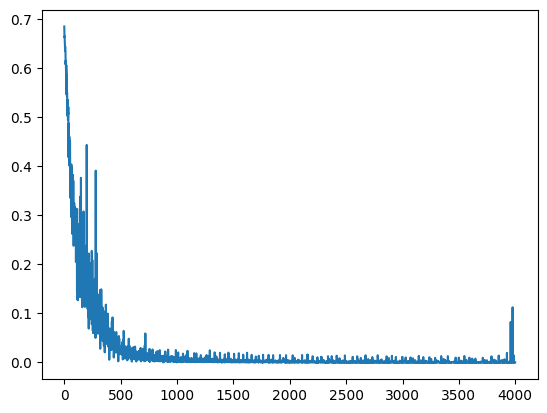

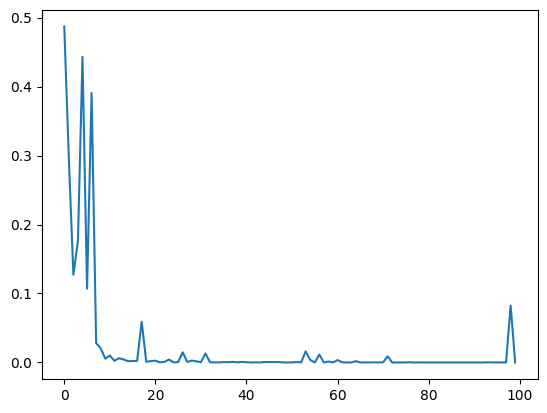

In [13]:
training_loop(my_moons_dataloader, model, loss_func, optimizer, 100)

Accuracy: 99.96000000000001%


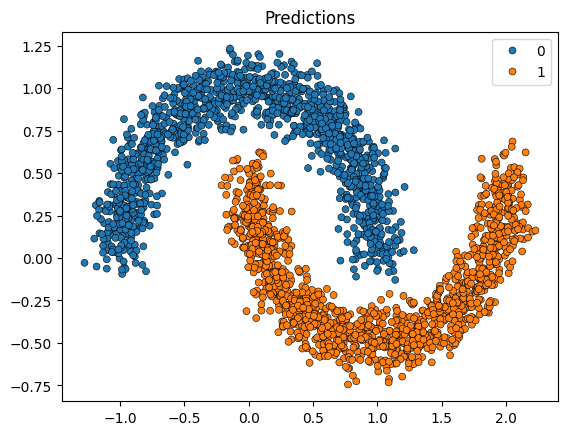

In [17]:
from sklearn.metrics import accuracy_score

predictions = model(X).sigmoid()

loss_func = nn.BCELoss()

predictions = predictions.detach().numpy().flatten()
predictions = (predictions > 0.5).astype(int)
accuracy = accuracy_score(y, predictions)
print(f"Accuracy: {accuracy * 100}%")

sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=predictions, marker="o", s=25, edgecolor="k", legend=True
).set_title("Predictions")
plt.show()

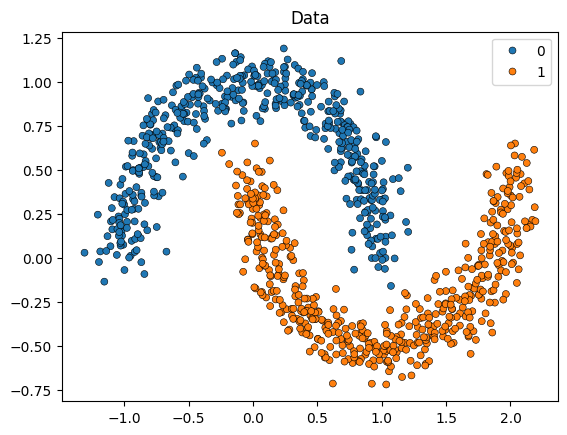

In [18]:
amount = 1000
points, labels = make_moons(n_samples=amount, shuffle=True, noise=0.1, random_state=2)

sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=labels, marker="o", s=25, edgecolor="k", legend=True
).set_title("Data")
plt.show()

X = torch.from_numpy(points).to(dtype=torch.float32)
y = torch.from_numpy(labels).to(dtype=torch.float32)

Accuracy: 99.9%


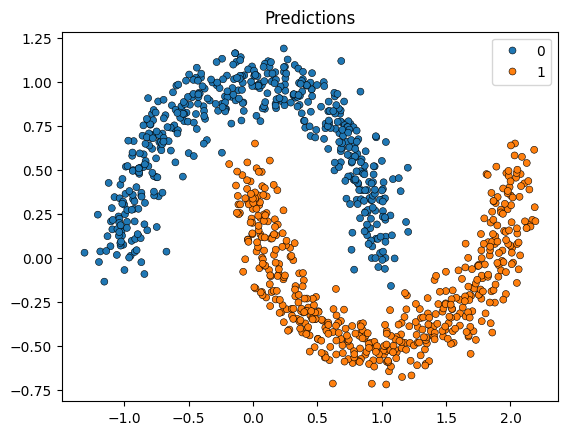

In [19]:
predictions = model(X).sigmoid()

loss_func = nn.BCELoss()

predictions = predictions.detach().numpy().flatten()
predictions = (predictions > 0.5).astype(int)
accuracy = accuracy_score(y, predictions)
print(f"Accuracy: {accuracy * 100}%")

sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=predictions, marker="o", s=25, edgecolor="k", legend=True
).set_title("Predictions")
plt.show()